# 4. word2vec 속도 개선
- 거대한 말뭉치일 때 2가지 문제가 제기됨
 1. 입력층의 원핫 표현과 가중치 행렬 Win의 곱계산 -> Embedding
 2. 은닉층과 가중치 행렬 Wout의 곱 및 Softmax 계층의 계산 -> Negative sampling
 
# 4.1 Embedding 계층
 - 가중치 매개변수로부터 '단어ID에 해당하는 행(벡터)'를 추출하는 계층
 - 단어 임베딩(분산표현)을 저장하는 계층
 - 문서는 단어장에 있는 단어의 개수와 같은 크기의 벡터가 되고 단어장의 각 단어가 그 문서에 나온 횟수만큼을 벡터 인덱스 위치의 숫자를 증가시킨다  
 - ex) 단어장에 'I','am','a','boy','girl'이라고 있으면 각각의 단어에 0부터 4까지의 숫자를 할당 할 수 있다 이때 'I am a girl'이라는 문서는 [1,1,1,0,1]이라는 벡터로 만들 수 있다 각각의 단어을 임베딩하게 된다면 'I':(0.3,0.2), 'am':(0.1,0.8), 'a':(0.5,0.6), 'boy':(0.2,0.9), 'girl':(0.4,0.7) 으로 변환이 가능한데 각 단어의 벡터를 합치거나 더하는 방식으로 전체문서의 벡터 표현을 구한다

In [ ]:
# Embedding 계층 구현 예제

import numpy as np

W0=np.arange(21) # [0,1,2,3,.....18,19,20]
W=np.arange(21).reshape(7,3) # W0를 7X3행렬로 reshape

print(W)
print()
print(W[2])
print()
print(W[5])

In [ ]:
# 가중치 W로부터 여러행을 한꺼번에 추출

idx=np.array([1,0,3,0])

print(W[idx])

In [ ]:
# Embedding 클래스

class Embedding:
    def __init__(self,W):
        self.params=[W]
        self.grads=[np.zeros_like(W)]
        self.idx=None # 추출려는 행의 인덱스(단어ID)
    
    # 순전파
    def forward(self,idx):
        W,=self.params
        self.idx=idx
        out=W[idx]
        return out
    
    # 역전파
    def backward(self,dout):
        dW,=self.params
        dW[...]=0 # dW의 형상을 유지하면서 원소만 0으로 변환
        
        '''
        중복 문제를 해결하려면 dW[self.idx]=dout으로 할당이 아니라
        dh의 각 행 값을 dW 해당 값에 더해주면 된다 
        할당을 하게 된다면 dW의 값이 덮어씌어지게 된다
        따라서 아래와 같이 for문으로 구현하면 된다
        for i i enumerate(self.idx):
            dW[self.idx]+=dout
        '''
        
        np.add.at(dW,self.idx,dout) # np.add.at(A,idx,B) : B를 A의 idx번째 행에 더함 
        return None

In [ ]:
# Embeddong class 확인

W=np.arange(21).reshape(7,3)
print('W: ')
print(W)
print()
idx=np.array([1,0,3,0])
EM=Embedding(W)
em_f=EM.forward(idx)
print('forward: ')
print(em_f) # 순전파
print()
em_b=EM.backward(em_f)
print('backward: ')
print(em_b) # 역전파

# 4.2 Negative Sampling
- Embedding 계층을 도입하여 계산시간을 줄였어도 은닉층 이후의 2가지 부분에서 계산이 오래 걸린다
 1. 은닉층의 뉴런과 가중치 행렬(Wout)의 곱
 2. Softmax 계층의 계산
- 다중 분류를 이진 분류로 근사하는 것이 Negative sampling의 핵심
- 즉, 신경망이 '타깃 단어가 say입니까?'라는 질문을 할 수 있게 만들어야함
- 계산 방식?
 1. 은닉층과 가중치 행렬의 내적 -> say에 해당하는 '열'만 추출
 2. 추출된 벡터와 은닉층 뉴런과 내적
- sigmoid 함수 사용
 1. 긍정(예) : sigmod 함수의 확률이 1에 가깝게
 2. 부정(아니오) : sigmod 함수의 확률이 0에 가깝게
 
- cross entropy error 함수 사용

In [ ]:
# EmbeddingDot class 구현

class EmbeddingDot:
    def __init__(self,W):
        self.embed=Embedding(W)
        self.params=self.embed.params # 매개변수 저장
        self.grads=self.embed.grads  # 기울기 저장
        self.cache=None # 순전파시 계산 결과를 잠지 유지하는 변수
        
    # 순전파
    def forward(self,h,idx): 
        '''
        h: 은닉층 뉴런 개수, idx : 단어ID 배열
        배열로 input하는 이유는 데이터를 한꺼번에 처리하는 
        미니배치 처리를 가정했기 때문이다
        '''
        target_W=self.embed.forward(idx) 
        out=np.sum(target_W*h,axis=1) # axis=1 : 행, axis=0 : 열
        self.cache=(h,target_W)
        return out
    
    # 역전파
    def backward(self,dout):
        h,target_W=self.cache
        dout=dout.reshape(dout.shape[0],1)
        dtarget_W=dout*h
        self.embed.backward(dtarget_W)
        dh=dout*target_W
        return dh

In [ ]:
# EmbeddingDot class 파라미터 및 변수값 확인

# 예제
W=np.arange(21).reshape(7,3)
idx=np.array([0,3,1])
h=np.arange(9).reshape(3,3)

# 순전파 target_W
EM=Embedding(W)
em_f=EM.forward(idx)
print('target_W')
print(em_f)

# 순전파 out
ED=EmbeddingDot(W)
ed_f=ED.forward(h,idx)
print()
print('out')
print(ed_f)
print()
print('target_W*h')
print(em_f*h)


# 순전파 cache
print()
print('cache')
print(ED.cache)

# 역전파 dout
d_out=ed_f.reshape(ed_f.shape[0],1)
print()
print('dout')
print(d_out)

# 역전파 dtarget_W

print()
print('dtarget_W')
print(ed_f*h)


# 역전파 dh

ed_b=ED.backward(ed_f)
print()
print('dh')
print(ed_b)

# ※ Nagative Sampling 샘플링 기법
- 적은 수 의 부정적인 예를 샘플링하여 사용 -> Negative Sampling의 의미
- 말뭉치 단어 빈도를 기준으로 샘플링 -> 말뭉치에서 자주 나오는 단어는 많이 추출, 적게 나오는 단어는 적게 추출 -> 확률분포로 추출
- Nagative Sampling의 확률분포에서 수정되야 할 것
 1. 기본 확률분포에 0.75를 제곱해야한다
 2. 수정후에도 확률의 총합은 1이 되어야함으로 수정 후 확률분포의 총합이 분모로 와야한다
 3. 0.75를 제곱하는 이유? -> 출현확률이 낮은 단어의 확률을 살짝 높여주어 단어를 버리는 일을 줄이기 위해서 이다

In [ ]:
# 0~9사이의 숫자 무작위 샘플링

np.random.choice(10)

In [ ]:
# words 리스트에서 하나만 무작위 샘플링

words=['you','say','goodbye','I','hello','.']
np.random.choice(words)

In [ ]:
# 중복있게 5개 샘플링

np.random.choice(words,size=5) # 샘플링 개수

In [ ]:
# 중복없이 5개 샘플링

np.random.choice(words,size=5,replace=False) # replace : 중복 유무

In [ ]:
# 확률분포에 따라 샘플링

p=[0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words,p=p)

In [ ]:
# 0.75를 제곱하여 샘플링

p=[0.7,0.29,0.01]
print('수정 전: ',p)
new_p=np.power(p,0.75) # 0.75 제곱
new_p/=np.sum(new_p)  # 각각 수정된 확률/수정된 확률의 총합
print('수정 후: ',new_p)

? 유니그램 / 바이그램 / 트라이그램
- 유니그램 : 하나의 연속된 단어
- 바이그램 : 두 개의 연속된 단어
- 트라이그램 :세 개의 연속된 단어

In [ ]:
# UnigramSampler class로 샘플링

import ch04.negative_sampling_layer as nsl

# UnigramSampler는 3개의 인수를 받음
corpus=np.array([0,1,2,3,4,1,2,3])
power=0.75
sample_size=2

# 샘플링
sampler=nsl.UnigramSampler(corpus,power,sample_size)
target=np.array([1,3,0])
negative_sample=sampler.get_negative_sample(target)
negative_sample # 실행시 결과 값 달라짐

In [ ]:
# negative Sampling class 구현

class NegativeSamplingLoss:
    def __inint__(self,W,corpus,power=0.75,sample_size=5): # power:확률분포 제곱 값
        self.sample_size=sample_size # sample_size:부정적 예의 샘플링 횟수
        self.sampler=UnigramSampler(corpus,power,sample_size)
        self.loss_layers=[sigmoidWithLoss() for _ in range(sample_size+1)] # 부정적인 계층을 다루는 계층 + 긍정적인 계층을 다루는 계층 1개
        self.embed_dpt_layers=[EmbeddingDot(W) for _ in range(sample_size+1)] # 0번째 꼐층이 긍정적인 계층을 다룸
        self.params, self.grads=[],[] # 매개변수, 기울기
        
        for layer in self.embed_dot_layers:
            self.params+=layer.params
            self.grads+=layer.grads
            
        # 순전파
        def forward(self,h,target): # h:은닉층 뉴런
            batch_size=target.shape[0]
            negative_sample=seld.sampler.get_negative_sample(target)
            
            # 긍정적인 예의 순전파
            scroe=self.embed_dot_layers[0].forward(h,target) # forward 점수 구함
            correct_label=np.ones(batch_size,dtype=np.int32) # 정답레이블:1
            loss=self.loss_layers[0].forward(score,correct_label) # forward 점수와 레이블을 흘려 손실 값 구함
            
            # 부정적인 예의 순전파
            negative_label=np.zeros(batch_size,dtype=np.int32) # 정답레이블:0
            for i in range(self.sample_size):
                negative_target=negative_sample[:,i]
                score=self.embed_dot_layers[1+i].forward(score,negative_label)
                # 순정파를 구하여 손실값을 더함
                
            return loss
        
        # 역전파
        def backward(self,dout=1):
            dh=0
            for l0,l1 in zip(self.loss_layers,self.embed_dot_layers):
                dscore=l0.backward(dout)
                dh+=l1.backward(dscore) # 여러개의 기울기값의 합
            
            return dh
        

# 4.3 word2vec 학습

In [ ]:
# CBOW 모델 구현

# 클래스 생성

class SimpleCBOW: # vocab_size:어휘수, hidden_size:은닉층의 뉴런수,window_size:맥락의 크기, corpus:단어ID목록
    def __init__(self,vocab_size,hidden_size,window_size,corpus):
        V,H=vocab_size,hidden_size
        
        # 가중치 초기화
        W_in=0.01*np.random.randn(V,H).asytpe('f') # 32bit 부동소수점 타입으로 변환
        W_out=0.01*np.random.randn(H,V).asytpe('f') # 32bit 부동소수점 타입으로 변환
        
        # 계층 생성
        self.in_layers=[]
        for i in range(2*window_size):
            layer=Embedding(W_in) # embedding 계층 사용
            self.in_layers.append(layer)
            self.ns_loss=NegativeSamplingLoss(W_out,corpus,power=0.75,sample_size=5)
            
        # 모든 가중치, 기울기를 리스트에 append
        layers=self.in_layers+[self.ns_loss]
        self.params,self.grads=[],[] # 매개변수, 기울기
        for layer in layers:
            self.parmas+=layer.paramas  # 가중치
            self.grads+=layer.grads   # 기울기
            
        # 인스턴스 변수에 단어의 분산 표현 저장
        self.word_vecs=W_in
    
    # 순전파
    def forward(self,contexts,target): # 앞장(단어ID를 원핫 벡터로 변환)과는 다르게 맥락과 타겟이 단어 ID이다
        h0=0
        for i, layer in eunmerate(self.in_layers):
            h+=layer.forward(contexta[:,i])
        h*=1/len(self.in_layers)
        loss=self.ns_layer.forward(h,target) # loss값 추출
        return loss
    
    # 역전파
    def backward(self,dout=1):
        dout=self.ns_layer.backward(dout)
        da*=1/len(self.in_layers)
        for layer in self.in_layres:
            layer.backward(dout)
        return None

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common import config
config.GPU=True # gpu 사용 cupy 설치
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW 
from common.util import create_contexts_target, to_cpu , to_gpu 
from dataset import ptb

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 0[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 0[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 1[s] | 손실 4.04
| 에폭 1 |  반복 101 / 9295 | 시간 1[s] | 손실 3.91
| 에폭 1 |  반복 121 / 9295 | 시간 1[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 1[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 2[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 2[s] | 손실 3.38
| 에폭 1 |  반복 201 / 9295 | 시간 2[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 3[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 3[s] | 손실 3.11
| 에폭 1 |  반복 261 / 9295 | 시간 3[s] | 손실 3.03
| 에폭 1 |  반복 281 / 9295 | 시간 3[s] | 손실 2.99
| 에폭 1 |  반복 301 / 9295 | 시간 4[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 4[s] | 손실 2.90
| 에폭 1 |  반복 341 / 9295 | 시간 4[s] | 손실 2.86
| 에폭 1 |  반복 361 / 9295 | 시간 4[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 5[s] | 손실 2.81
| 에폭 1 |  반복 401 / 9295 | 시간 5[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 5[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 | 시간 5[s] | 손실

| 에폭 1 |  반복 3621 / 9295 | 시간 48[s] | 손실 2.44
| 에폭 1 |  반복 3641 / 9295 | 시간 48[s] | 손실 2.43
| 에폭 1 |  반복 3661 / 9295 | 시간 49[s] | 손실 2.44
| 에폭 1 |  반복 3681 / 9295 | 시간 49[s] | 손실 2.43
| 에폭 1 |  반복 3701 / 9295 | 시간 49[s] | 손실 2.42
| 에폭 1 |  반복 3721 / 9295 | 시간 49[s] | 손실 2.45
| 에폭 1 |  반복 3741 / 9295 | 시간 50[s] | 손실 2.43
| 에폭 1 |  반복 3761 / 9295 | 시간 50[s] | 손실 2.43
| 에폭 1 |  반복 3781 / 9295 | 시간 50[s] | 손실 2.41
| 에폭 1 |  반복 3801 / 9295 | 시간 50[s] | 손실 2.39
| 에폭 1 |  반복 3821 / 9295 | 시간 51[s] | 손실 2.41
| 에폭 1 |  반복 3841 / 9295 | 시간 51[s] | 손실 2.38
| 에폭 1 |  반복 3861 / 9295 | 시간 51[s] | 손실 2.42
| 에폭 1 |  반복 3881 / 9295 | 시간 52[s] | 손실 2.42
| 에폭 1 |  반복 3901 / 9295 | 시간 52[s] | 손실 2.40
| 에폭 1 |  반복 3921 / 9295 | 시간 52[s] | 손실 2.40
| 에폭 1 |  반복 3941 / 9295 | 시간 52[s] | 손실 2.43
| 에폭 1 |  반복 3961 / 9295 | 시간 53[s] | 손실 2.41
| 에폭 1 |  반복 3981 / 9295 | 시간 53[s] | 손실 2.42
| 에폭 1 |  반복 4001 / 9295 | 시간 53[s] | 손실 2.40
| 에폭 1 |  반복 4021 / 9295 | 시간 53[s] | 손실 2.40
| 에폭 1 |  반복 4041 / 9295 | 시간 54[s

| 에폭 1 |  반복 7201 / 9295 | 시간 96[s] | 손실 2.29
| 에폭 1 |  반복 7221 / 9295 | 시간 97[s] | 손실 2.32
| 에폭 1 |  반복 7241 / 9295 | 시간 97[s] | 손실 2.30
| 에폭 1 |  반복 7261 / 9295 | 시간 97[s] | 손실 2.27
| 에폭 1 |  반복 7281 / 9295 | 시간 97[s] | 손실 2.33
| 에폭 1 |  반복 7301 / 9295 | 시간 98[s] | 손실 2.29
| 에폭 1 |  반복 7321 / 9295 | 시간 98[s] | 손실 2.34
| 에폭 1 |  반복 7341 / 9295 | 시간 98[s] | 손실 2.32
| 에폭 1 |  반복 7361 / 9295 | 시간 98[s] | 손실 2.31
| 에폭 1 |  반복 7381 / 9295 | 시간 99[s] | 손실 2.28
| 에폭 1 |  반복 7401 / 9295 | 시간 99[s] | 손실 2.29
| 에폭 1 |  반복 7421 / 9295 | 시간 99[s] | 손실 2.30
| 에폭 1 |  반복 7441 / 9295 | 시간 100[s] | 손실 2.31
| 에폭 1 |  반복 7461 / 9295 | 시간 100[s] | 손실 2.29
| 에폭 1 |  반복 7481 / 9295 | 시간 100[s] | 손실 2.29
| 에폭 1 |  반복 7501 / 9295 | 시간 100[s] | 손실 2.32
| 에폭 1 |  반복 7521 / 9295 | 시간 101[s] | 손실 2.29
| 에폭 1 |  반복 7541 / 9295 | 시간 101[s] | 손실 2.28
| 에폭 1 |  반복 7561 / 9295 | 시간 101[s] | 손실 2.32
| 에폭 1 |  반복 7581 / 9295 | 시간 101[s] | 손실 2.30
| 에폭 1 |  반복 7601 / 9295 | 시간 102[s] | 손실 2.28
| 에폭 1 |  반복 7621 / 9295 

| 에폭 2 |  반복 1421 / 9295 | 시간 144[s] | 손실 2.16
| 에폭 2 |  반복 1441 / 9295 | 시간 144[s] | 손실 2.11
| 에폭 2 |  반복 1461 / 9295 | 시간 144[s] | 손실 2.16
| 에폭 2 |  반복 1481 / 9295 | 시간 145[s] | 손실 2.18
| 에폭 2 |  반복 1501 / 9295 | 시간 145[s] | 손실 2.17
| 에폭 2 |  반복 1521 / 9295 | 시간 145[s] | 손실 2.18
| 에폭 2 |  반복 1541 / 9295 | 시간 145[s] | 손실 2.19
| 에폭 2 |  반복 1561 / 9295 | 시간 146[s] | 손실 2.16
| 에폭 2 |  반복 1581 / 9295 | 시간 146[s] | 손실 2.16
| 에폭 2 |  반복 1601 / 9295 | 시간 146[s] | 손실 2.12
| 에폭 2 |  반복 1621 / 9295 | 시간 147[s] | 손실 2.14
| 에폭 2 |  반복 1641 / 9295 | 시간 147[s] | 손실 2.18
| 에폭 2 |  반복 1661 / 9295 | 시간 147[s] | 손실 2.16
| 에폭 2 |  반복 1681 / 9295 | 시간 147[s] | 손실 2.16
| 에폭 2 |  반복 1701 / 9295 | 시간 148[s] | 손실 2.16
| 에폭 2 |  반복 1721 / 9295 | 시간 148[s] | 손실 2.18
| 에폭 2 |  반복 1741 / 9295 | 시간 148[s] | 손실 2.19
| 에폭 2 |  반복 1761 / 9295 | 시간 148[s] | 손실 2.14
| 에폭 2 |  반복 1781 / 9295 | 시간 149[s] | 손실 2.18
| 에폭 2 |  반복 1801 / 9295 | 시간 149[s] | 손실 2.16
| 에폭 2 |  반복 1821 / 9295 | 시간 149[s] | 손실 2.14
| 에폭 2 |  반복 

| 에폭 2 |  반복 4921 / 9295 | 시간 191[s] | 손실 2.09
| 에폭 2 |  반복 4941 / 9295 | 시간 191[s] | 손실 2.09
| 에폭 2 |  반복 4961 / 9295 | 시간 192[s] | 손실 2.11
| 에폭 2 |  반복 4981 / 9295 | 시간 192[s] | 손실 2.09
| 에폭 2 |  반복 5001 / 9295 | 시간 192[s] | 손실 2.11
| 에폭 2 |  반복 5021 / 9295 | 시간 193[s] | 손실 2.10
| 에폭 2 |  반복 5041 / 9295 | 시간 193[s] | 손실 2.12
| 에폭 2 |  반복 5061 / 9295 | 시간 193[s] | 손실 2.11
| 에폭 2 |  반복 5081 / 9295 | 시간 193[s] | 손실 2.07
| 에폭 2 |  반복 5101 / 9295 | 시간 194[s] | 손실 2.11
| 에폭 2 |  반복 5121 / 9295 | 시간 194[s] | 손실 2.10
| 에폭 2 |  반복 5141 / 9295 | 시간 194[s] | 손실 2.09
| 에폭 2 |  반복 5161 / 9295 | 시간 194[s] | 손실 2.08
| 에폭 2 |  반복 5181 / 9295 | 시간 195[s] | 손실 2.06
| 에폭 2 |  반복 5201 / 9295 | 시간 195[s] | 손실 2.13
| 에폭 2 |  반복 5221 / 9295 | 시간 195[s] | 손실 2.09
| 에폭 2 |  반복 5241 / 9295 | 시간 195[s] | 손실 2.07
| 에폭 2 |  반복 5261 / 9295 | 시간 196[s] | 손실 2.08
| 에폭 2 |  반복 5281 / 9295 | 시간 196[s] | 손실 2.08
| 에폭 2 |  반복 5301 / 9295 | 시간 196[s] | 손실 2.10
| 에폭 2 |  반복 5321 / 9295 | 시간 197[s] | 손실 2.10
| 에폭 2 |  반복 

| 에폭 2 |  반복 8421 / 9295 | 시간 239[s] | 손실 2.08
| 에폭 2 |  반복 8441 / 9295 | 시간 239[s] | 손실 2.06
| 에폭 2 |  반복 8461 / 9295 | 시간 239[s] | 손실 2.02
| 에폭 2 |  반복 8481 / 9295 | 시간 240[s] | 손실 2.07
| 에폭 2 |  반복 8501 / 9295 | 시간 240[s] | 손실 2.04
| 에폭 2 |  반복 8521 / 9295 | 시간 240[s] | 손실 2.06
| 에폭 2 |  반복 8541 / 9295 | 시간 240[s] | 손실 2.04
| 에폭 2 |  반복 8561 / 9295 | 시간 241[s] | 손실 2.02
| 에폭 2 |  반복 8581 / 9295 | 시간 241[s] | 손실 2.03
| 에폭 2 |  반복 8601 / 9295 | 시간 241[s] | 손실 2.07
| 에폭 2 |  반복 8621 / 9295 | 시간 242[s] | 손실 2.05
| 에폭 2 |  반복 8641 / 9295 | 시간 242[s] | 손실 2.05
| 에폭 2 |  반복 8661 / 9295 | 시간 242[s] | 손실 2.05
| 에폭 2 |  반복 8681 / 9295 | 시간 242[s] | 손실 2.05
| 에폭 2 |  반복 8701 / 9295 | 시간 243[s] | 손실 2.02
| 에폭 2 |  반복 8721 / 9295 | 시간 243[s] | 손실 2.03
| 에폭 2 |  반복 8741 / 9295 | 시간 243[s] | 손실 2.03
| 에폭 2 |  반복 8761 / 9295 | 시간 243[s] | 손실 2.03
| 에폭 2 |  반복 8781 / 9295 | 시간 244[s] | 손실 2.04
| 에폭 2 |  반복 8801 / 9295 | 시간 244[s] | 손실 2.06
| 에폭 2 |  반복 8821 / 9295 | 시간 244[s] | 손실 2.07
| 에폭 2 |  반복 

| 에폭 3 |  반복 2641 / 9295 | 시간 287[s] | 손실 1.98
| 에폭 3 |  반복 2661 / 9295 | 시간 287[s] | 손실 1.97
| 에폭 3 |  반복 2681 / 9295 | 시간 287[s] | 손실 1.98
| 에폭 3 |  반복 2701 / 9295 | 시간 288[s] | 손실 1.93
| 에폭 3 |  반복 2721 / 9295 | 시간 288[s] | 손실 1.99
| 에폭 3 |  반복 2741 / 9295 | 시간 288[s] | 손실 1.95
| 에폭 3 |  반복 2761 / 9295 | 시간 288[s] | 손실 1.94
| 에폭 3 |  반복 2781 / 9295 | 시간 289[s] | 손실 1.96
| 에폭 3 |  반복 2801 / 9295 | 시간 289[s] | 손실 1.94
| 에폭 3 |  반복 2821 / 9295 | 시간 289[s] | 손실 1.91
| 에폭 3 |  반복 2841 / 9295 | 시간 289[s] | 손실 1.95
| 에폭 3 |  반복 2861 / 9295 | 시간 290[s] | 손실 1.97
| 에폭 3 |  반복 2881 / 9295 | 시간 290[s] | 손실 1.94
| 에폭 3 |  반복 2901 / 9295 | 시간 290[s] | 손실 1.92
| 에폭 3 |  반복 2921 / 9295 | 시간 291[s] | 손실 1.99
| 에폭 3 |  반복 2941 / 9295 | 시간 291[s] | 손실 1.93
| 에폭 3 |  반복 2961 / 9295 | 시간 291[s] | 손실 2.00
| 에폭 3 |  반복 2981 / 9295 | 시간 291[s] | 손실 1.97
| 에폭 3 |  반복 3001 / 9295 | 시간 292[s] | 손실 1.95
| 에폭 3 |  반복 3021 / 9295 | 시간 292[s] | 손실 1.96
| 에폭 3 |  반복 3041 / 9295 | 시간 292[s] | 손실 1.98
| 에폭 3 |  반복 

| 에폭 3 |  반복 6141 / 9295 | 시간 334[s] | 손실 1.88
| 에폭 3 |  반복 6161 / 9295 | 시간 335[s] | 손실 1.97
| 에폭 3 |  반복 6181 / 9295 | 시간 335[s] | 손실 1.91
| 에폭 3 |  반복 6201 / 9295 | 시간 335[s] | 손실 1.93
| 에폭 3 |  반복 6221 / 9295 | 시간 336[s] | 손실 1.89
| 에폭 3 |  반복 6241 / 9295 | 시간 336[s] | 손실 1.93
| 에폭 3 |  반복 6261 / 9295 | 시간 336[s] | 손실 1.94
| 에폭 3 |  반복 6281 / 9295 | 시간 336[s] | 손실 1.95
| 에폭 3 |  반복 6301 / 9295 | 시간 337[s] | 손실 1.92
| 에폭 3 |  반복 6321 / 9295 | 시간 337[s] | 손실 1.95
| 에폭 3 |  반복 6341 / 9295 | 시간 337[s] | 손실 1.93
| 에폭 3 |  반복 6361 / 9295 | 시간 337[s] | 손실 1.93
| 에폭 3 |  반복 6381 / 9295 | 시간 338[s] | 손실 1.95
| 에폭 3 |  반복 6401 / 9295 | 시간 338[s] | 손실 1.95
| 에폭 3 |  반복 6421 / 9295 | 시간 338[s] | 손실 1.89
| 에폭 3 |  반복 6441 / 9295 | 시간 339[s] | 손실 1.95
| 에폭 3 |  반복 6461 / 9295 | 시간 339[s] | 손실 1.93
| 에폭 3 |  반복 6481 / 9295 | 시간 339[s] | 손실 1.91
| 에폭 3 |  반복 6501 / 9295 | 시간 339[s] | 손실 1.91
| 에폭 3 |  반복 6521 / 9295 | 시간 340[s] | 손실 1.92
| 에폭 3 |  반복 6541 / 9295 | 시간 340[s] | 손실 1.94
| 에폭 3 |  반복 

| 에폭 4 |  반복 341 / 9295 | 시간 382[s] | 손실 1.85
| 에폭 4 |  반복 361 / 9295 | 시간 382[s] | 손실 1.88
| 에폭 4 |  반복 381 / 9295 | 시간 383[s] | 손실 1.84
| 에폭 4 |  반복 401 / 9295 | 시간 383[s] | 손실 1.84
| 에폭 4 |  반복 421 / 9295 | 시간 383[s] | 손실 1.86
| 에폭 4 |  반복 441 / 9295 | 시간 384[s] | 손실 1.85
| 에폭 4 |  반복 461 / 9295 | 시간 384[s] | 손실 1.81
| 에폭 4 |  반복 481 / 9295 | 시간 384[s] | 손실 1.87
| 에폭 4 |  반복 501 / 9295 | 시간 384[s] | 손실 1.85
| 에폭 4 |  반복 521 / 9295 | 시간 385[s] | 손실 1.82
| 에폭 4 |  반복 541 / 9295 | 시간 385[s] | 손실 1.84
| 에폭 4 |  반복 561 / 9295 | 시간 385[s] | 손실 1.83
| 에폭 4 |  반복 581 / 9295 | 시간 385[s] | 손실 1.84
| 에폭 4 |  반복 601 / 9295 | 시간 386[s] | 손실 1.81
| 에폭 4 |  반복 621 / 9295 | 시간 386[s] | 손실 1.86
| 에폭 4 |  반복 641 / 9295 | 시간 386[s] | 손실 1.86
| 에폭 4 |  반복 661 / 9295 | 시간 387[s] | 손실 1.86
| 에폭 4 |  반복 681 / 9295 | 시간 387[s] | 손실 1.83
| 에폭 4 |  반복 701 / 9295 | 시간 387[s] | 손실 1.85
| 에폭 4 |  반복 721 / 9295 | 시간 387[s] | 손실 1.82
| 에폭 4 |  반복 741 / 9295 | 시간 388[s] | 손실 1.83
| 에폭 4 |  반복 761 / 9295 | 시간 388[s

| 에폭 4 |  반복 3861 / 9295 | 시간 430[s] | 손실 1.85
| 에폭 4 |  반복 3881 / 9295 | 시간 430[s] | 손실 1.83
| 에폭 4 |  반복 3901 / 9295 | 시간 431[s] | 손실 1.82
| 에폭 4 |  반복 3921 / 9295 | 시간 431[s] | 손실 1.85
| 에폭 4 |  반복 3941 / 9295 | 시간 431[s] | 손실 1.82
| 에폭 4 |  반복 3961 / 9295 | 시간 431[s] | 손실 1.82
| 에폭 4 |  반복 3981 / 9295 | 시간 432[s] | 손실 1.83
| 에폭 4 |  반복 4001 / 9295 | 시간 432[s] | 손실 1.85
| 에폭 4 |  반복 4021 / 9295 | 시간 432[s] | 손실 1.86
| 에폭 4 |  반복 4041 / 9295 | 시간 433[s] | 손실 1.84
| 에폭 4 |  반복 4061 / 9295 | 시간 433[s] | 손실 1.82
| 에폭 4 |  반복 4081 / 9295 | 시간 433[s] | 손실 1.83
| 에폭 4 |  반복 4101 / 9295 | 시간 433[s] | 손실 1.82
| 에폭 4 |  반복 4121 / 9295 | 시간 434[s] | 손실 1.82
| 에폭 4 |  반복 4141 / 9295 | 시간 434[s] | 손실 1.84
| 에폭 4 |  반복 4161 / 9295 | 시간 434[s] | 손실 1.83
| 에폭 4 |  반복 4181 / 9295 | 시간 434[s] | 손실 1.80
| 에폭 4 |  반복 4201 / 9295 | 시간 435[s] | 손실 1.85
| 에폭 4 |  반복 4221 / 9295 | 시간 435[s] | 손실 1.84
| 에폭 4 |  반복 4241 / 9295 | 시간 435[s] | 손실 1.82
| 에폭 4 |  반복 4261 / 9295 | 시간 436[s] | 손실 1.82
| 에폭 4 |  반복 

| 에폭 4 |  반복 7361 / 9295 | 시간 478[s] | 손실 1.86
| 에폭 4 |  반복 7381 / 9295 | 시간 478[s] | 손실 1.83
| 에폭 4 |  반복 7401 / 9295 | 시간 478[s] | 손실 1.83
| 에폭 4 |  반복 7421 / 9295 | 시간 479[s] | 손실 1.82
| 에폭 4 |  반복 7441 / 9295 | 시간 479[s] | 손실 1.85
| 에폭 4 |  반복 7461 / 9295 | 시간 479[s] | 손실 1.82
| 에폭 4 |  반복 7481 / 9295 | 시간 479[s] | 손실 1.82
| 에폭 4 |  반복 7501 / 9295 | 시간 480[s] | 손실 1.82
| 에폭 4 |  반복 7521 / 9295 | 시간 480[s] | 손실 1.80
| 에폭 4 |  반복 7541 / 9295 | 시간 480[s] | 손실 1.80
| 에폭 4 |  반복 7561 / 9295 | 시간 481[s] | 손실 1.82
| 에폭 4 |  반복 7581 / 9295 | 시간 481[s] | 손실 1.79
| 에폭 4 |  반복 7601 / 9295 | 시간 481[s] | 손실 1.80
| 에폭 4 |  반복 7621 / 9295 | 시간 481[s] | 손실 1.83
| 에폭 4 |  반복 7641 / 9295 | 시간 482[s] | 손실 1.82
| 에폭 4 |  반복 7661 / 9295 | 시간 482[s] | 손실 1.84
| 에폭 4 |  반복 7681 / 9295 | 시간 482[s] | 손실 1.82
| 에폭 4 |  반복 7701 / 9295 | 시간 482[s] | 손실 1.83
| 에폭 4 |  반복 7721 / 9295 | 시간 483[s] | 손실 1.83
| 에폭 4 |  반복 7741 / 9295 | 시간 483[s] | 손실 1.85
| 에폭 4 |  반복 7761 / 9295 | 시간 483[s] | 손실 1.83
| 에폭 4 |  반복 

| 에폭 5 |  반복 1581 / 9295 | 시간 526[s] | 손실 1.80
| 에폭 5 |  반복 1601 / 9295 | 시간 526[s] | 손실 1.75
| 에폭 5 |  반복 1621 / 9295 | 시간 526[s] | 손실 1.78
| 에폭 5 |  반복 1641 / 9295 | 시간 527[s] | 손실 1.74
| 에폭 5 |  반복 1661 / 9295 | 시간 527[s] | 손실 1.74
| 에폭 5 |  반복 1681 / 9295 | 시간 527[s] | 손실 1.75
| 에폭 5 |  반복 1701 / 9295 | 시간 527[s] | 손실 1.76
| 에폭 5 |  반복 1721 / 9295 | 시간 528[s] | 손실 1.73
| 에폭 5 |  반복 1741 / 9295 | 시간 528[s] | 손실 1.74
| 에폭 5 |  반복 1761 / 9295 | 시간 528[s] | 손실 1.75
| 에폭 5 |  반복 1781 / 9295 | 시간 529[s] | 손실 1.76
| 에폭 5 |  반복 1801 / 9295 | 시간 529[s] | 손실 1.75
| 에폭 5 |  반복 1821 / 9295 | 시간 529[s] | 손실 1.76
| 에폭 5 |  반복 1841 / 9295 | 시간 529[s] | 손실 1.74
| 에폭 5 |  반복 1861 / 9295 | 시간 530[s] | 손실 1.73
| 에폭 5 |  반복 1881 / 9295 | 시간 530[s] | 손실 1.76
| 에폭 5 |  반복 1901 / 9295 | 시간 530[s] | 손실 1.71
| 에폭 5 |  반복 1921 / 9295 | 시간 530[s] | 손실 1.80
| 에폭 5 |  반복 1941 / 9295 | 시간 531[s] | 손실 1.75
| 에폭 5 |  반복 1961 / 9295 | 시간 531[s] | 손실 1.76
| 에폭 5 |  반복 1981 / 9295 | 시간 531[s] | 손실 1.72
| 에폭 5 |  반복 

| 에폭 5 |  반복 5081 / 9295 | 시간 573[s] | 손실 1.74
| 에폭 5 |  반복 5101 / 9295 | 시간 574[s] | 손실 1.73
| 에폭 5 |  반복 5121 / 9295 | 시간 574[s] | 손실 1.75
| 에폭 5 |  반복 5141 / 9295 | 시간 574[s] | 손실 1.71
| 에폭 5 |  반복 5161 / 9295 | 시간 575[s] | 손실 1.75
| 에폭 5 |  반복 5181 / 9295 | 시간 575[s] | 손실 1.74
| 에폭 5 |  반복 5201 / 9295 | 시간 575[s] | 손실 1.74
| 에폭 5 |  반복 5221 / 9295 | 시간 575[s] | 손실 1.71
| 에폭 5 |  반복 5241 / 9295 | 시간 576[s] | 손실 1.72
| 에폭 5 |  반복 5261 / 9295 | 시간 576[s] | 손실 1.75
| 에폭 5 |  반복 5281 / 9295 | 시간 576[s] | 손실 1.73
| 에폭 5 |  반복 5301 / 9295 | 시간 577[s] | 손실 1.75
| 에폭 5 |  반복 5321 / 9295 | 시간 577[s] | 손실 1.76
| 에폭 5 |  반복 5341 / 9295 | 시간 577[s] | 손실 1.74
| 에폭 5 |  반복 5361 / 9295 | 시간 577[s] | 손실 1.76
| 에폭 5 |  반복 5381 / 9295 | 시간 578[s] | 손실 1.77
| 에폭 5 |  반복 5401 / 9295 | 시간 578[s] | 손실 1.76
| 에폭 5 |  반복 5421 / 9295 | 시간 578[s] | 손실 1.72
| 에폭 5 |  반복 5441 / 9295 | 시간 578[s] | 손실 1.77
| 에폭 5 |  반복 5461 / 9295 | 시간 579[s] | 손실 1.79
| 에폭 5 |  반복 5481 / 9295 | 시간 579[s] | 손실 1.78
| 에폭 5 |  반복 

| 에폭 5 |  반복 8581 / 9295 | 시간 621[s] | 손실 1.72
| 에폭 5 |  반복 8601 / 9295 | 시간 622[s] | 손실 1.74
| 에폭 5 |  반복 8621 / 9295 | 시간 622[s] | 손실 1.71
| 에폭 5 |  반복 8641 / 9295 | 시간 622[s] | 손실 1.75
| 에폭 5 |  반복 8661 / 9295 | 시간 622[s] | 손실 1.75
| 에폭 5 |  반복 8681 / 9295 | 시간 623[s] | 손실 1.76
| 에폭 5 |  반복 8701 / 9295 | 시간 623[s] | 손실 1.76
| 에폭 5 |  반복 8721 / 9295 | 시간 623[s] | 손실 1.73
| 에폭 5 |  반복 8741 / 9295 | 시간 623[s] | 손실 1.72
| 에폭 5 |  반복 8761 / 9295 | 시간 624[s] | 손실 1.72
| 에폭 5 |  반복 8781 / 9295 | 시간 624[s] | 손실 1.75
| 에폭 5 |  반복 8801 / 9295 | 시간 624[s] | 손실 1.71
| 에폭 5 |  반복 8821 / 9295 | 시간 625[s] | 손실 1.75
| 에폭 5 |  반복 8841 / 9295 | 시간 625[s] | 손실 1.72
| 에폭 5 |  반복 8861 / 9295 | 시간 625[s] | 손실 1.73
| 에폭 5 |  반복 8881 / 9295 | 시간 625[s] | 손실 1.71
| 에폭 5 |  반복 8901 / 9295 | 시간 626[s] | 손실 1.71
| 에폭 5 |  반복 8921 / 9295 | 시간 626[s] | 손실 1.75
| 에폭 5 |  반복 8941 / 9295 | 시간 626[s] | 손실 1.71
| 에폭 5 |  반복 8961 / 9295 | 시간 626[s] | 손실 1.71
| 에폭 5 |  반복 8981 / 9295 | 시간 627[s] | 손실 1.72
| 에폭 5 |  반복 

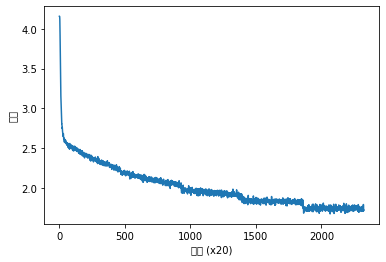

In [8]:
# CBOW 모델 학습

# 파라미터 설정
window_size=5
hidden_size=100
batch_size=100
max_epoch=5

# 데이터 읽기
corpus,word_to_id,id_to_word=ptb.load_data('train')
vocab_size=len(word_to_id)

contexts,target=create_contexts_target(corpus,window_size)
if config.GPU:
    contexts,target=to_gpu(contexts),to_gpu(target) 

# 모델 생성
model=CBOW(vocab_size,hidden_size,window_size,corpus)
optimizer=Adam()
trainer=Trainer(model,optimizer)

# 학습시작
trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot()

# 추후 사용하기 위해 필요데이터 저장
word_vecs=model.word_vecs
if config.GPU:
    word_vecs=to_cpu(word_vecs)

params={}
params['word_vecs']=word_vecs.astype(np.float16)
params['word_to_id']=word_to_id
params['id_to_word']=id_to_word
pkl_file='cbow_params.pkl'
with open(pkl_file,'wb') as f:
    pickle.dump(params,f,-1)